## QUESTION 1 :  FREQUENCY TRANSFORMS

In [1]:
import cv2
from matplotlib import pyplot as plt

(321, 481)


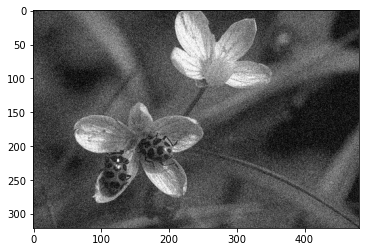

In [2]:
## read and display the image 
image = cv2.imread("ladybug.jpg",0)
plt.imshow(image, cmap = 'gray')
print(image.shape)


In [3]:
import numpy as np 

In [4]:
def convolve2d(image, kernel):
    '''
    this function applies convolution with the given kernel. It applies zero padding  and then 
    multiplies the kernel values with the corresponding image pixel values. Then it slides over the image
    and the multiplication process is then completed. Our new pixel is the sum of the multiplied 
    pixel values in each 3x3 block since the kernel used is a 3x3 filter. 
    '''
    output = np.zeros_like(image)
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    image_padded[1:-1, 1:-1] = image

    # Loop over every pixel of the image and add the product of the sum of each pixel in the 
    # iamge and the kernel to the output, output is our convolved image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y, x]=(kernel * image_padded[y: y+3, x: x+3]).sum()

    return output

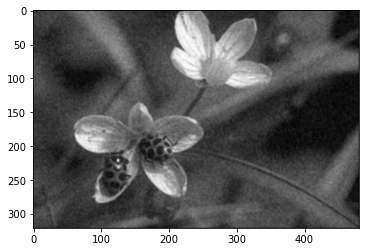

In [5]:
#define box filter
boxfilter =np.array([[1, 1, 1], [1,1 ,1], [1,1,1]])/9
#apply convolution 
imageboxblur = convolve2d(image,boxfilter)
#plot the result
plt.imshow(imageboxblur, cmap = 'gray')

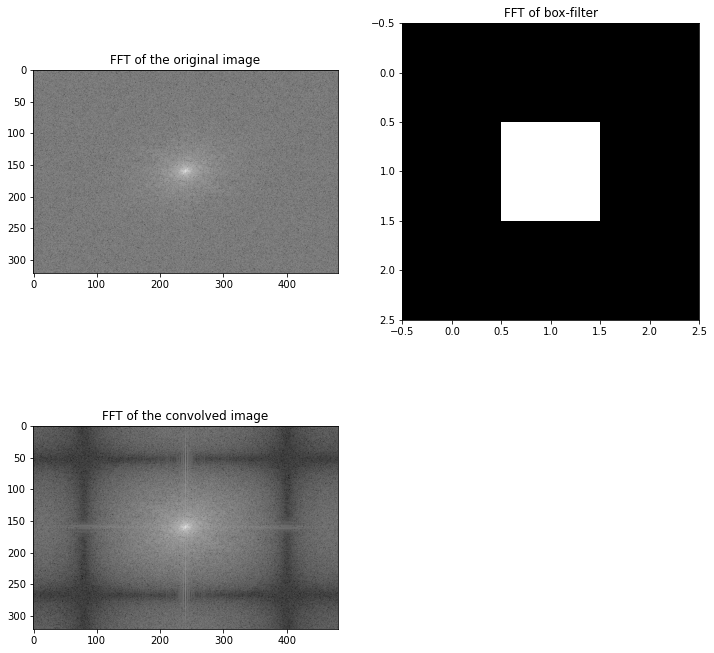

In [6]:
#transform the image, the filter and the filtered image into frequency domain
fft_image = np.fft.fft2(image)
fft_kernel = np.fft.fft2(boxfilter)
fft_filtered_image = np.fft.fft2(imageboxblur)
#apply shift for display purposes
shifted_image = np.fft.fftshift(fft_image)
shifted_kernel = np.fft.fftshift(fft_kernel)
shifted_filtered_image = np.fft.fftshift(fft_filtered_image)

#plot the results
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('FFT of the original image')
ax1.imshow(np.log(1+np.abs(shifted_image)), cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(np.log(1+np.abs(shifted_kernel)), cmap='gray')
ax2.title.set_text('FFT of box-filter')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(np.log(1+np.abs(shifted_filtered_image)), cmap='gray')
ax3.title.set_text('FFT of the convolved image')


### Question 2 : Image restoration 

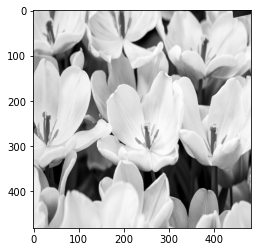

In [7]:
#read and display the image
image = cv2.imread("flowers-min.jpg",0)
image = cv2.resize(image, (481, 481))
plt.imshow(image,cmap = 'gray')

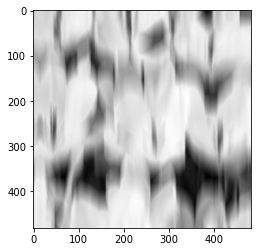

In [8]:
motion_filter = np.zeros((50,50))
# create a mask containing ones on a certain area columns of the mask to create a vertical motion 
motion_filter[:,10] = np.ones(50)

# normalize the mask by the filter size 
normalized_filter = motion_filter/50

#perform convolution to apply the filter
motion_blur_image = cv2.filter2D(image, -1, normalized_filter)
plt.imshow(motion_blur_image, cmap = 'gray')

In [9]:
def gaussian_noise(image): 
    '''
    this method add gaussian noise with std = 20 to the given image 
    
    '''
    noise = np.random.normal(0, 20, image.shape) #generate noise 
    noisy = image + noise ## add the noise 
    return noisy

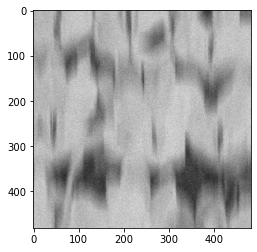

In [10]:
#add gaussian noise to the blured image and display the result
blurred_noisy_image = gaussian_noise(motion_blur_image)
plt.imshow(blurred_noisy_image, cmap = 'gray')

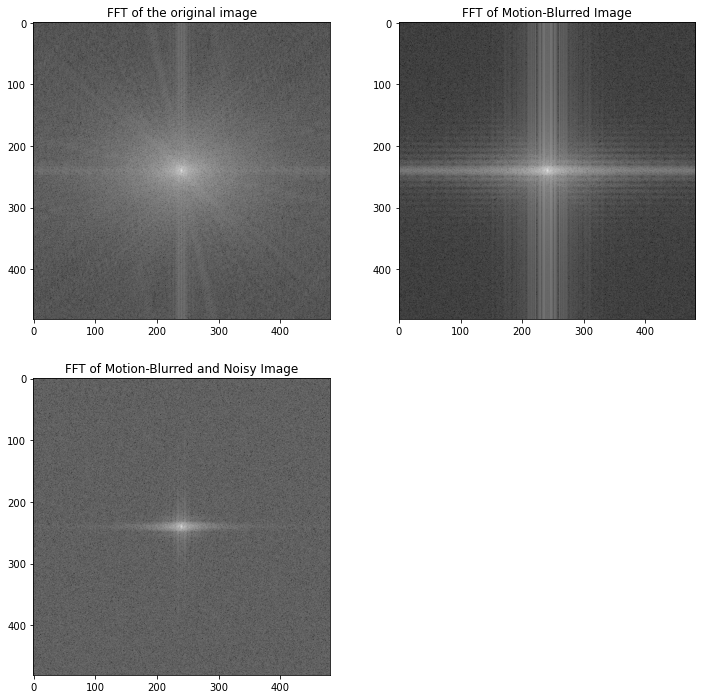

In [11]:
#transform the image, the filter and the filtered image into frequency domain
fft_image = np.fft.fft2(image)
fft_blur = np.fft.fft2(motion_blur_image)
fft_noisy_blur = np.fft.fft2(blurred_noisy_image)

shifted_image = np.fft.fftshift(fft_image)
shifted_blur = np.fft.fftshift(fft_blur)
shifted_noisy_blur = np.fft.fftshift(fft_noisy_blur)

#plot the results
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('FFT of the original image')
ax1.imshow(np.log(1+np.abs(shifted_image)), cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(np.log(1+np.abs(shifted_blur)), cmap='gray')
ax2.title.set_text('FFT of Motion-Blurred Image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(np.log(1+np.abs(shifted_noisy_blur)), cmap='gray')
ax3.title.set_text('FFT of Motion-Blurred and Noisy Image')



In [12]:
from scipy.signal import gaussian

In [13]:
#create the kernel for wiener filtering 
h = gaussian(50, 14/3).reshape(50, 1)
h = np.dot(h, h.transpose())
h /= np.sum(h)

In [14]:
#wiener filter
def wiener_filter(img, h, K):
    h /= np.sum(h)
    temp = np.copy(img)
    # transform the image into frequency domain
    temp = np.fft.fft2(temp)
    # fourier transform the degradation 
    h = np.fft.fft2(h, s = img.shape)
    ## calculate the filter kernel
    h =  1/h * (np.abs(np.conj(h) ** 2) / (np.abs(h) ** 2 + K))
    #apply convolution 
    temp = temp * h
    #take inverse Fourier Transform
    temp = np.abs(np.fft.ifft2(temp))
    return temp

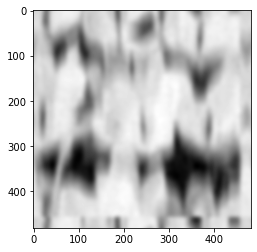

In [15]:
#apply wiener filter to the degraded image and display the results
wiener_image = wiener_filter(blurred_noisy_image,h,5)
plt.imshow(wiener_image, cmap = 'gray')

In [16]:
def inverse_filter(image):
    #transform the image into the frequenc domain
    fft_image = np.fft.fft2(image)
    shift_image = np.fft.fftshift(fft_image)
    
    #estimate the degradation 
    deg = image * shift_image

    # apply deconvolution to inverse filter
    inv = deg / image

    # apply inverse inverse fft to convert the image into spatial domain
    inverse = np.fft.ifft2(np.fft.ifftshift(inv))
    #make sure the type remains uint8 
    inverse = np.asarray(inverse, dtype = np.uint8)
    return inverse

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


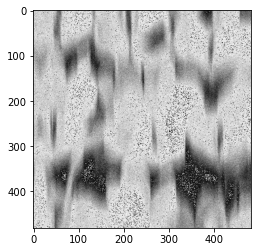

In [17]:
#apply the inverse filter to restore the image
inverse_image = inverse_filter(blurred_noisy_image)
plt.imshow(inverse_image, cmap = 'gray')

### Question 3 : Morphology

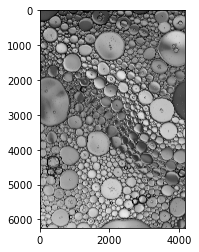

In [18]:
## read the image 
bubbles = cv2.imread('granulometry1-min.jpg',0)
plt.imshow(bubbles,cmap='gray')

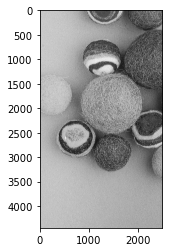

In [19]:
ball = cv2.imread('granulometry2-min.jpg',0)
plt.imshow(ball,cmap='gray')

In [20]:
## to reduce the effect of noisiness we can introduce a preprocessing method to get rid of noise,
## that way, we can get better results for the edge detection 

def medianFiltering(image):
    temp = []
    filter_size =3
    ## an indexer to keep track of the median 
    indexer = filter_size// 2
    output = []
    height = len(image)
    width = len(image[0])
    ##create the output array
    output = np.zeros((height,width))
    ##loop over the image 
    for i in range(height):

        for j in range(width):
            
            for z in range(filter_size):
                ## compute the neighbors according to the filtersize
                if i + z - indexer < 0 or i + z - indexer > height - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    ## compute the neighbors according to the filtersize
                    if j + z - indexer < 0 or j + indexer > width - 1:
                        temp.append(0)
                        ## compute the neighbors according to the filtersize
                    else:
                        for k in range(filter_size):
                            temp.append(image[i + z - indexer][j + k - indexer])
            # once all the neighbors are found sort the list of neighbors
            temp.sort()
            ## place each pixel with the median value 
            output[i][j] = temp[len(temp)// 2]
            temp = []
    return output

In [21]:
## apply median filter to reduce the potential noise from the image 
bubbles = medianFiltering(bubbles)

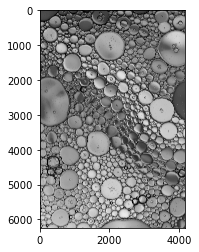

In [22]:
plt.imshow(bubbles,cmap = 'gray')

In [23]:
ball = medianFiltering(ball)

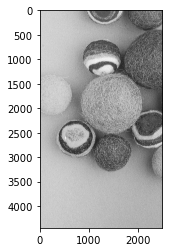

In [24]:
plt.imshow(ball,cmap='gray')

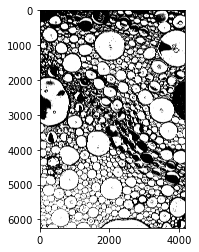

In [26]:
## apply thresholding to the image 
ret,threshold = cv2.threshold(bubbles.astype(np.uint8),0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(threshold,cmap = 'gray')

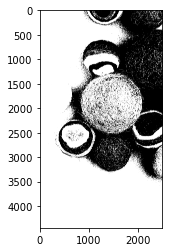

In [27]:
ret,threshold_ball = cv2.threshold(ball.astype(np.uint8),0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(threshold_ball,cmap = 'gray')

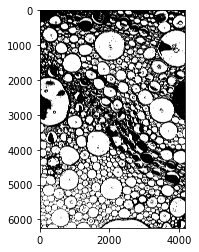

In [28]:
# apply morphological opening, first erode and dilate both images using the structure element
# named kernel 
kernel = np.ones((3,3),np.uint8)
eroded_image = cv2.erode(threshold,kernel,iterations = 1)
plt.imshow(eroded_image,cmap = 'gray')
dilated_image = cv2.dilate(eroded_image, kernel, iterations = 1)

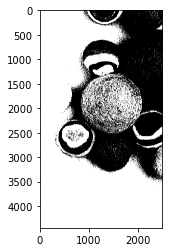

In [29]:
eroded_ball = cv2.erode(threshold_ball,kernel,iterations = 1)
plt.imshow(eroded_ball,cmap = 'gray')
dilated_ball = cv2.dilate(eroded_ball, kernel, iterations = 1)

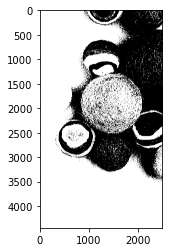

In [30]:
plt.imshow(dilated_ball,cmap='gray')

In [31]:
#create binary boolean image 
mask = (dilated_image == 255)
mask_ball = (dilated_ball == 255)

In [32]:
from skimage import io,color,measure
from scipy import ndimage

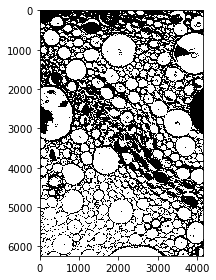

In [33]:
io.imshow(mask)

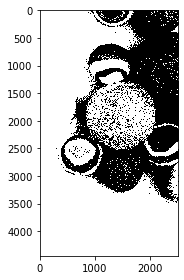

In [34]:
io.imshow(mask_ball)

5796


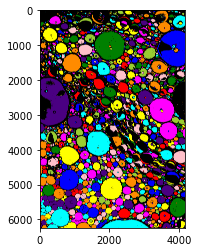

In [35]:
s = [[1,1,1],[1,1,1],[1,1,1]] # structure factor 8-connectivity
#apply connected components algorithm 
label_mask, num_labels = ndimage.label(mask,structure = s)
res = color.label2rgb(label_mask, bg_label = 0)
plt.imshow(res)
print(num_labels)

3877


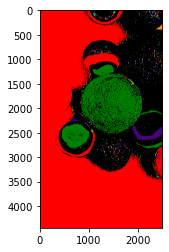

In [36]:
label_mask_ball, num_labels_ball = ndimage.label(mask_ball,structure = s)
res_ball = color.label2rgb(label_mask_ball, bg_label = 0)
plt.imshow(res_ball)
print(num_labels_ball)

In [37]:
clusters = measure.regionprops(label_mask, bubbles)
## calculate the areas of the grains
grain_areas = []
for grain in clusters: 
    grain_areas.append(grain.area)

print("The number of grains detected : ",num_labels)
print("Largest grain area : ", max(grain_areas))
print("Smallest grain area : ",min(grain_areas))
print("Mean grain area : ", sum(grain_areas)/num_labels)

The number of grains detected :  5796
Largest grain area :  714944
Smallest grain area :  6
Mean grain area :  2698.0213940648723


(array([5.465e+03, 1.400e+02, 7.400e+01, 3.100e+01, 2.100e+01, 1.100e+01,
        1.000e+01, 3.000e+00, 1.100e+01, 4.000e+00]),
 array([    0.,  8000., 16000., 24000., 32000., 40000., 48000., 56000.,
        64000., 72000., 80000.]),
 <a list of 10 Patch objects>)

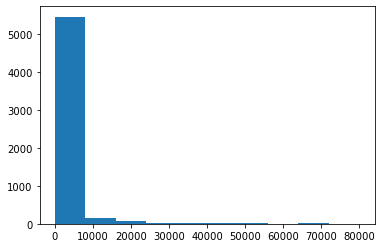

In [38]:
plt.hist(grain_areas, bins = 10,range = ((0,80000)))

(array([4675.,  347.,  148.,  105.,   61.,   51.,   44.,   34.,   22.,
          29.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

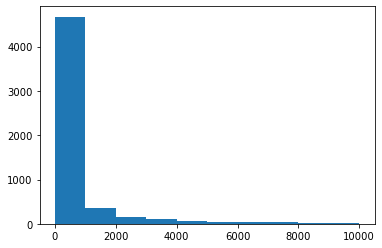

In [39]:
plt.hist(grain_areas, bins = 10,range = ((0,10000)))

In [40]:
clusters_ball = measure.regionprops(label_mask_ball, ball)
## calculate the areas of the grains
grain_areas_ball = []
for grain in clusters_ball: 
    grain_areas_ball.append(grain.area)

print("The number of grains detected : ",num_labels_ball)
print("Largest grain area : ", max(grain_areas_ball))
print("Smallest grain area : ",min(grain_areas_ball))
print("Mean grain area : ", sum(grain_areas_ball)/num_labels_ball)

The number of grains detected :  3877
Largest grain area :  6048159
Smallest grain area :  6
Mean grain area :  1923.4575702863037


(array([3295.,  330.,  111.,   50.,   26.,   14.,   15.,    8.,    4.,
           6.]),
 array([  0.,  60., 120., 180., 240., 300., 360., 420., 480., 540., 600.]),
 <a list of 10 Patch objects>)

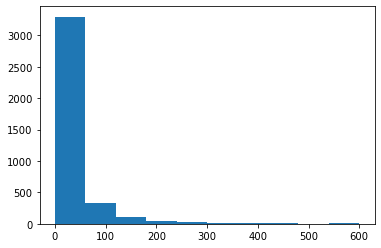

In [41]:
plt.hist(grain_areas_ball, bins = 10,range = ((0,600)))

### Question 4 : PCA Face Detection

In [42]:
a = cv2.imread("face1.jpg")
a.shape

(512, 512, 3)

In [43]:
    width = 512 ## all images in the dataset have the same dimensionality.
    height = 512
    face_vectors = []
    ## create the face vectors reshape them all in a same size 
    for i in range(1, 11):
        image_file = "face" + str(i) + ".jpg"
        face_image = cv2.imread(image_file,0) ## read the image
        face_image = face_image.reshape(width*height,) ## convert it to a one dimensional vector
        face_vectors.append(face_image)
    
    face_vectors = np.asarray(face_vectors)
    ## we transpose the vector since we want all information to be stored in axis 0 
    face_vectors = face_vectors.transpose() 

    print("Face vectors shape = " , face_vectors.shape)
    print("Face vectors : ", face_vectors)

Face vectors shape =  (262144, 10)
Face vectors :  [[162 181 180 ... 186 213 191]
 [163 180 180 ... 186 214 191]
 [163 179 180 ... 186 214 192]
 ...
 [168 163  27 ... 190  48  51]
 [168 159  32 ... 188  53  64]
 [163 152  36 ... 184  57  71]]


In [46]:
mean_vector = face_vectors.mean(axis=1)
mean_vector = mean_vector.reshape(face_vectors.shape[0], 1)
norm_vector = face_vectors - mean_vector
print(norm_vector)

[[ -21.8   -2.8   -3.8 ...    2.2   29.2    7.2]
 [ -21.    -4.    -4.  ...    2.    30.     7. ]
 [ -21.1   -5.1   -4.1 ...    1.9   29.9    7.9]
 ...
 [  32.6   27.6 -108.4 ...   54.6  -87.4  -84.4]
 [  32.    23.  -104.  ...   52.   -83.   -72. ]
 [  29.1   18.1  -97.9 ...   50.1  -76.9  -62.9]]


In [47]:
# Calculate the covariance matrix C' =  AA^T
cov_matrix = np.cov(np.transpose(norm_vector))
print("Covariance Matrix : ", cov_matrix)

Covariance Matrix :  [[1043.36970612 -135.96505384 -302.21713356 -349.7940082   208.06755594
  -212.42342156 -248.66945766  104.18551728 -111.06008815    4.50638362]
 [-135.96505384 2793.28051742 -694.96822498  275.75636166 -148.97465375
  -307.59722549 -208.01106552  -17.09640476 -959.38616916 -597.03808157]
 [-302.21713356 -694.96822498 2433.932098   -517.9001112  -350.4857361
  -351.65459832  -99.18778446 -136.62689268  513.4936454  -494.3852621 ]
 [-349.7940082   275.75636166 -517.9001112  2666.19051277 -878.4358834
   740.51463105 -795.94235934 -683.2835648  -164.85476041 -292.25081813]
 [ 208.06755594 -148.97465375 -350.4857361  -878.4358834  1415.74174404
  -373.99752583  173.65118488  156.07050578 -444.5364318   242.89924024]
 [-212.42342156 -307.59722549 -351.65459832  740.51463105 -373.99752583
  1169.73111428   49.27442474 -141.5086054  -227.2570737  -345.08171977]
 [-248.66945766 -208.01106552  -99.18778446 -795.94235934  173.65118488
    49.27442474 1675.66839948  552.4155

In [48]:
#compute the eigen values and eigen vectors using covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
print(eigen_vectors.shape)
print("Eigen vectors : ",eigen_vectors)

(10, 10)
Eigen vectors :  [[-0.02515787  0.10511581 -0.18244832  0.08622524  0.31622777  0.3874029
   0.05326052  0.46857607 -0.68927585  0.00362489]
 [ 0.60732666  0.11680882  0.15847065  0.64189176  0.31622777  0.07321359
  -0.14945173 -0.02273891  0.19385565  0.12074323]
 [-0.42571716 -0.07572238  0.66116415  0.15544591  0.31622777  0.04644154
  -0.0875308   0.03209964  0.03209323 -0.48974559]
 [ 0.39486036 -0.63223212 -0.00986038 -0.24143645  0.31622777 -0.07535457
   0.47368403 -0.0500228  -0.0343002  -0.22857254]
 [-0.05751565  0.35739019 -0.25796379  0.03522658  0.31622777 -0.10725062
   0.09854327 -0.73908472 -0.2819559  -0.23285008]
 [ 0.14261423 -0.19643639  0.04941877 -0.45363682  0.31622777  0.02304405
  -0.7631009  -0.12893815 -0.09275021  0.15736486]
 [ 0.0146906   0.40275202  0.21836341 -0.43055847  0.31622777  0.42890162
   0.33223744 -0.01250493  0.35406581  0.29095451]
 [ 0.01463669  0.30325666  0.07429395 -0.13044948  0.31622777 -0.79637688
   0.08748712  0.35180487 

In [49]:
#select 10 eigenvectors
k_eigen_vectors = eigen_vectors[0:10, :]
print("K- eigenvectors : ", k_eigen_vectors)

K- eigenvectors :  [[-0.02515787  0.10511581 -0.18244832  0.08622524  0.31622777  0.3874029
   0.05326052  0.46857607 -0.68927585  0.00362489]
 [ 0.60732666  0.11680882  0.15847065  0.64189176  0.31622777  0.07321359
  -0.14945173 -0.02273891  0.19385565  0.12074323]
 [-0.42571716 -0.07572238  0.66116415  0.15544591  0.31622777  0.04644154
  -0.0875308   0.03209964  0.03209323 -0.48974559]
 [ 0.39486036 -0.63223212 -0.00986038 -0.24143645  0.31622777 -0.07535457
   0.47368403 -0.0500228  -0.0343002  -0.22857254]
 [-0.05751565  0.35739019 -0.25796379  0.03522658  0.31622777 -0.10725062
   0.09854327 -0.73908472 -0.2819559  -0.23285008]
 [ 0.14261423 -0.19643639  0.04941877 -0.45363682  0.31622777  0.02304405
  -0.7631009  -0.12893815 -0.09275021  0.15736486]
 [ 0.0146906   0.40275202  0.21836341 -0.43055847  0.31622777  0.42890162
   0.33223744 -0.01250493  0.35406581  0.29095451]
 [ 0.01463669  0.30325666  0.07429395 -0.13044948  0.31622777 -0.79637688
   0.08748712  0.35180487 -0.0461

In [50]:
## create the eigenfaces by multiplying normalized face vectors and k-sleected eigenvectors
eigen_faces = k_eigen_vectors.dot(np.transpose(norm_vector))
print(eigen_faces.shape)

(10, 262144)


In [51]:
weights = np.transpose(norm_vector).dot(np.transpose(eigen_faces))
print("Weights: ", weights)

Weights:  [[-1.10998874e+07  1.22151289e+08 -1.25060263e+08  1.44475705e+08
   1.09898804e+07  1.37663411e+08 -4.22274018e+07  9.39207336e+07
  -1.34346550e+08 -6.29785957e+07]
 [ 2.13179219e+08  1.68595439e+07 -6.09426100e+07 -4.79187327e+08
   4.30521731e+08 -1.73844317e+08  1.02357440e+07  2.59412585e+08
  -3.50949217e+08 -2.32266111e+07]
 [-6.14384280e+08  5.92344731e+07  8.08619257e+08  1.12742365e+08
  -7.13361948e+07 -2.33071887e+07 -8.48130461e+07  2.67194021e+08
  -1.28037289e+08 -9.72362564e+08]
 [-3.66402285e+07  3.70506111e+08  1.13157441e+08 -4.05312653e+08
   1.76715786e+08 -2.68789301e+08 -4.30031694e+08 -3.38550244e+08
   1.03211077e+08 -9.56058682e+07]
 [ 2.24351294e+08 -7.00029304e+07 -9.85726143e+07  2.34686184e+08
   9.02919839e+07  2.29063957e+08  1.56124013e+08  1.95512404e+08
   9.03037251e+07  1.84291226e+08]
 [ 3.26869272e+08 -5.24605810e+07 -1.86711176e+08 -4.68090065e+07
  -9.63755934e+07 -5.72210907e+07  1.17590591e+07 -5.16236278e+08
   5.22946151e+07  4.83

In [54]:
def face_detected(image):

    image = image.reshape(512*512, 1)
    #normalize the input image according to the information in the training set 
    norm = image - mean_vector

    #get the weight from previously calculated normalized faces and the eigen vectors
    weight = np.transpose(norm).dot(np.transpose(eigen_faces))
    #calculate the distance 
    differences = np.linalg.norm(weight - weights, axis=1)
    ## calculate the magnitude threshold 
    magnitude = np.linalg.norm(np.sum(weight)*2.3)
    minDistance = np.argmin(np.linalg.norm(weights - weight, axis=1))
    #if the magnitude is grater than the minimum difference, then the face is detected 
    if differences.min() <= magnitude:
        return print("Face detected : ", True)
    else:
        return print("Face detected : ", False)

Face detected :  True
Face detected :  True
Face detected :  False


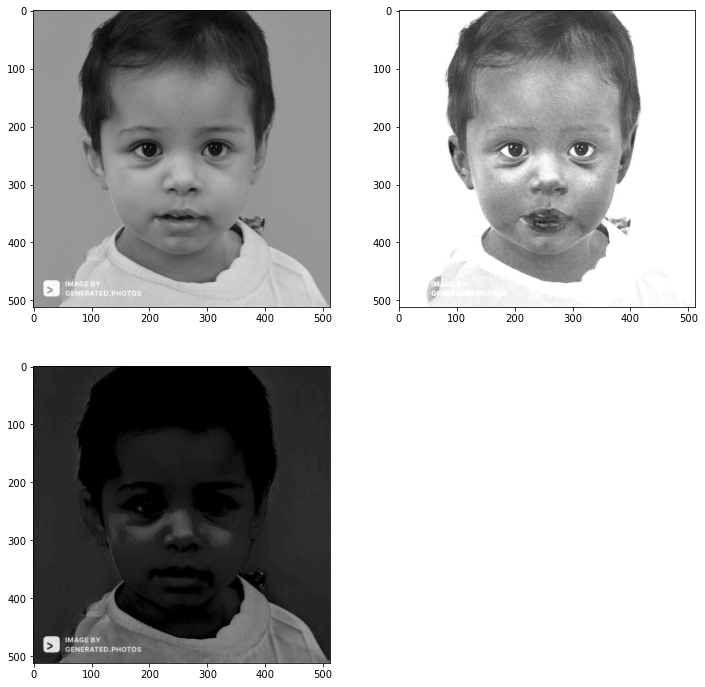

In [55]:
test1 = cv2.imread("test1.jpg",0) ## original image
test2 = cv2.imread("test2.jpg",0) ## lighter image
test3 = cv2.imread("test.3.jpg",0) ## darker image
face_detected(test1)
face_detected(test2)
face_detected(test3)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(test3, cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(test2, cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(test1, cmap='gray')

Face detected :  False
Face detected :  True


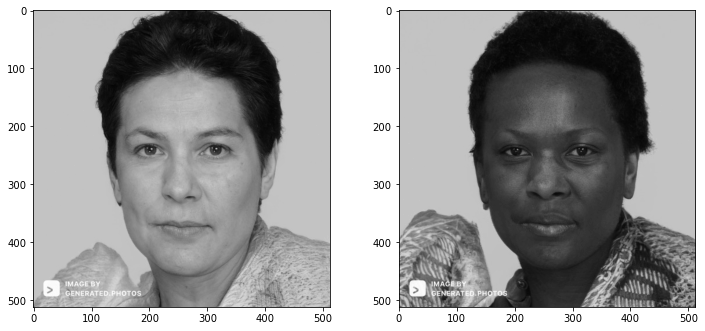

In [56]:
test4 = cv2.imread("test4.jpg",0)
test5 = cv2.imread("test5.jpg",0)
face_detected(test4)
face_detected(test5)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(test4, cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(test5, cmap='gray')


Face detected :  False
Face detected :  True


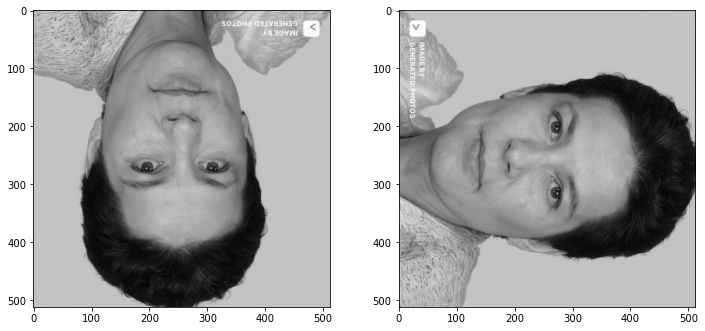

In [57]:
test6 = cv2.imread("test6.jpg",0)
test7 = cv2.imread("test7.jpg",0)
face_detected(test6)
face_detected(test7)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(test6, cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(test7, cmap='gray')

Face detected :  True
Face detected :  True
Face detected :  True


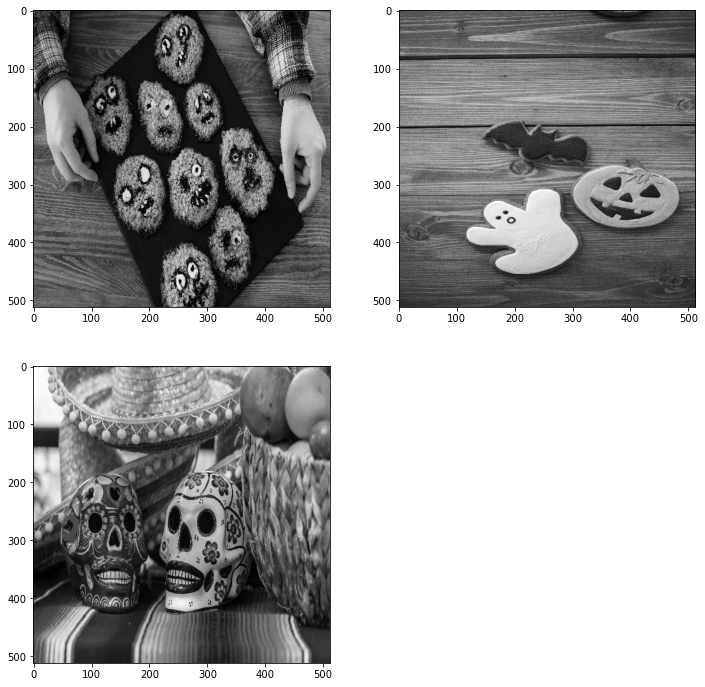

In [58]:
test8 = cv2.imread("cookies-min.jpg",0)
test8 = cv2.resize(test8,(512,512))
test9 = cv2.imread("halloween-min.jpg",0)
test9 = cv2.resize(test9,(512,512))
test10 = cv2.imread("skulls.jpg",0)
test10 = cv2.resize(test10,(512,512))
face_detected(test8)
face_detected(test9)
face_detected(test10)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(test8, cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(test9, cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(test10, cmap='gray')

Face detected :  True
Face detected :  False
Face detected :  False


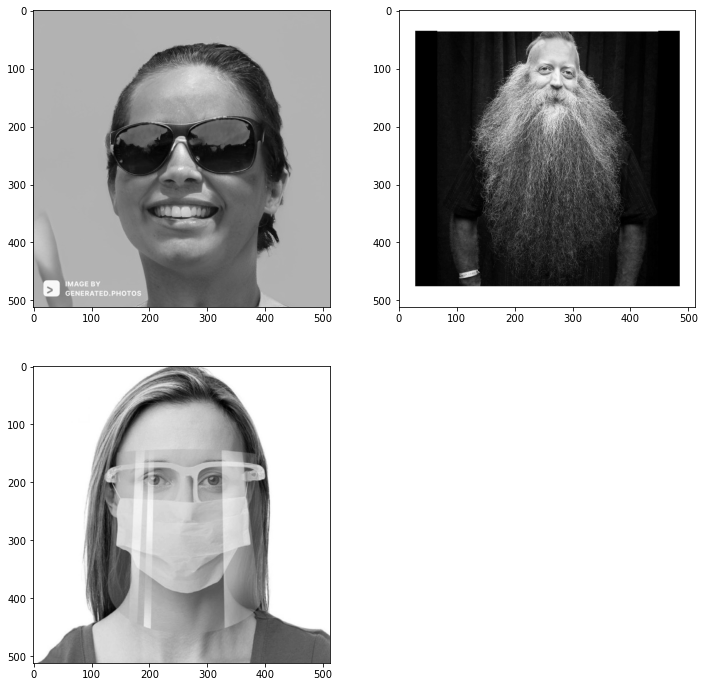

In [59]:
test11 = cv2.imread("test11.jpg",0)
test11= cv2.resize(test11,(512,512))
test12= cv2.imread("test12.jpg",0)
test12= cv2.resize(test12,(512,512))
test13 = cv2.imread("test13.jpg",0)
test13 = cv2.resize(test13,(512,512))
face_detected(test11)
face_detected(test12)
face_detected(test13)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(test11, cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(test12, cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(test13, cmap='gray')

### Question 5

In [60]:
from sklearn.preprocessing import normalize

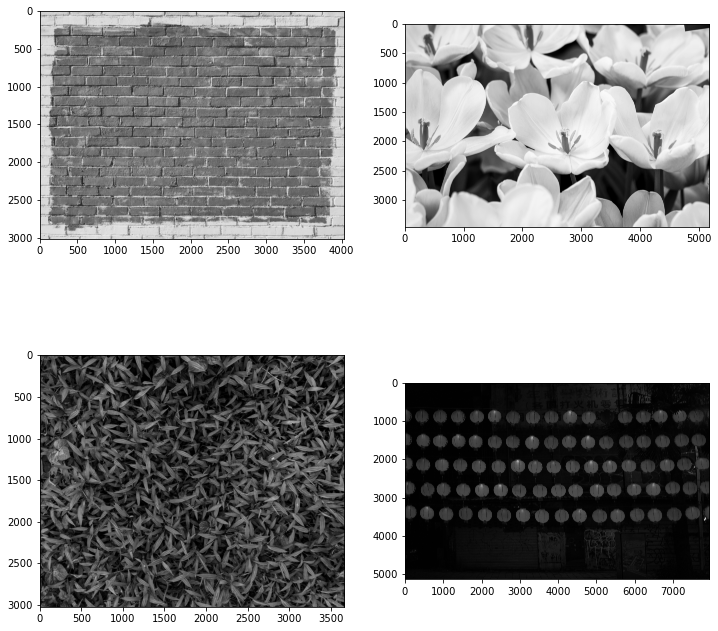

In [61]:
#read and display
bricks = cv2.imread("bricks-min.jpg", 0)
flower = cv2.imread("flowers-min.jpg", 0)
grass = cv2.imread("grass-min.jpg", 0)
lamps = cv2.imread("lamps-min.jpg", 0)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(bricks, cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(flower, cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(grass, cmap='gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(lamps, cmap='gray')

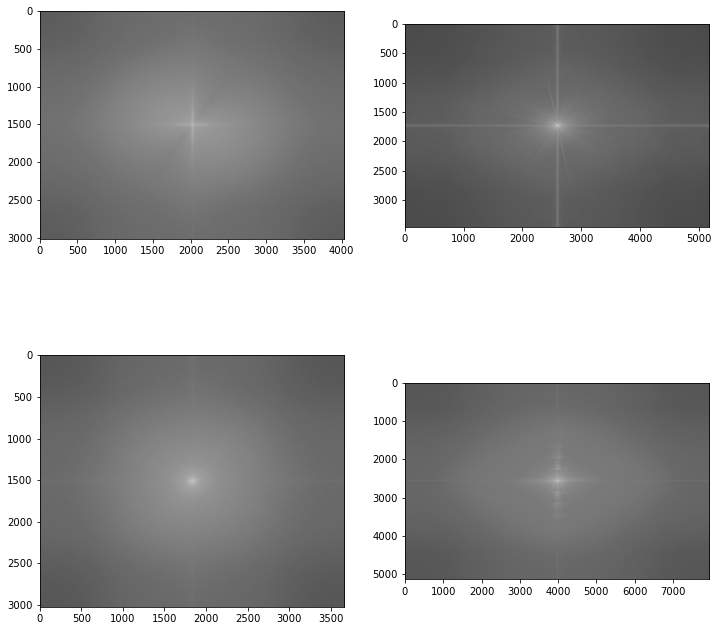

In [62]:
#apply fourier transform
fft_bricks = np.fft.fft2(bricks)
fft_flower = np.fft.fft2(flower)
fft_grass = np.fft.fft2(grass)
fft_lamps = np.fft.fft2(lamps)

shift_bricks = np.fft.fftshift(fft_bricks)
shift_flower = np.fft.fftshift(fft_flower)
shift_grass = np.fft.fftshift(fft_grass)
shift_lamps = np.fft.fftshift(fft_lamps)

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.log(1+np.abs(shift_bricks)), cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(np.log(1+np.abs(shift_flower)), cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(np.log(1+np.abs(shift_grass)), cmap='gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(np.log(1+np.abs(shift_lamps)), cmap='gray')

In [63]:
## calculate power spectrum og the image by taking the sum of the squares of the real part
## of the fft image and the complex term of the fft image
def power_spec(fft): 
    real = np.real(fft)
    complx= np.imag(fft)
    power = real**2 + complx**2
    return power
    

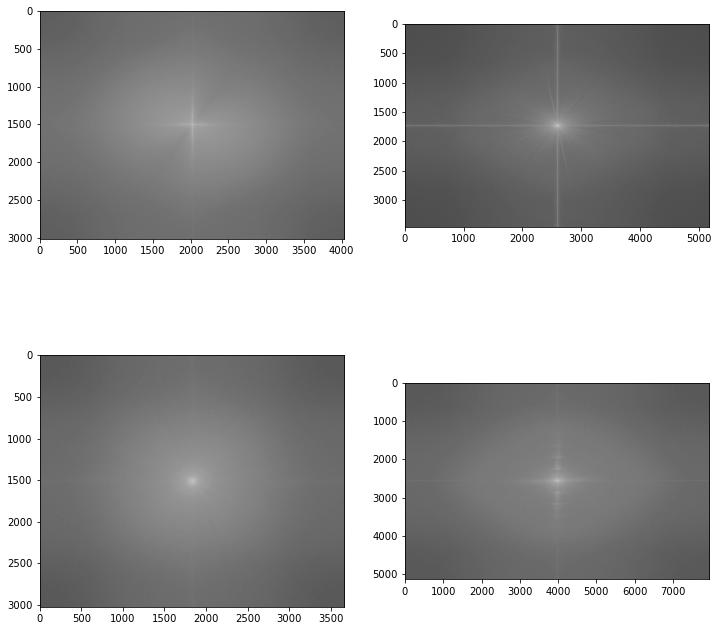

In [64]:
##apply fft to display the power spectrum 
ps_bricks = np.fft.fftshift(power_spec(fft_bricks))
ps_flower = np.fft.fftshift(power_spec(fft_flower))
ps_grass = np.fft.fftshift(power_spec(fft_grass))
ps_lamps = np.fft.fftshift(power_spec(fft_lamps))
#display
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.log(1+np.abs(ps_bricks)), cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(np.log(1+np.abs(ps_flower)), cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(np.log(1+np.abs(ps_grass)), cmap='gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(np.log(1+np.abs(ps_lamps)), cmap='gray')

In [65]:
#calculate the PS Entropy
def ps_entropy(image, vectorized_img):
    # normalize power spectrum values
    norm= normalize(vectorized_img[:,np.newaxis], axis=0).ravel()# creates a normalized 1D array
    i= image.shape[0]
    j = image.shape[1]
    entropy = 0
    for x in range(j * i):
        add = norm[x]*np.log(norm[x])
        entropy = entropy + add

    return entropy

In [66]:
## vectorize each image by flattening them into 1D arrays 
v_bricks = ps_bricks.flatten()
v_flower = ps_flower.flatten()
v_grass = ps_grass.flatten()
v_lamps = ps_lamps.flatten()

In [67]:
#calculate power sprectrum entropy of each image 
e_bricks = ps_entropy(bricks, v_bricks)
print("Power spectrum entropy of bricks image : ", e_bricks)
e_flower = ps_entropy(flower,v_flower)
print("Power spectrum entropy of flower image : ", e_flower)
e_grass = ps_entropy(grass,v_grass)
print("Power spectrum entropy of grass image : ", e_grass)
e_lamps = ps_entropy(lamps, v_lamps)
print("Power spectrum entropy of lamps image : ", e_lamps)



Power spectrum entropy of bricks image :  -1.5209776123688261
Power spectrum entropy of flower image :  -1.191841225482021
Power spectrum entropy of grass image :  -5.919871444655877
Power spectrum entropy of lamps image :  -7.787276445089702
